# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import json
import seaborn as sns

In [3]:
review = []

with open('yelp_academic_dataset_review.json') as file:
      for line in file:
            review.append(json.loads(line))

review = pd.DataFrame(review)
review = review.dropna()

In [5]:
#review.to_csv(r'Desktop\eview.csv', index = False)
review.to_csv(r'/Users/langchen777/Desktop/review.csv', index = False)

In [7]:
business = []

with open('yelp_academic_dataset_business.json') as file:
    for line in file:
        business.append(json.loads(line))

business = pd.DataFrame(business)
business = business.dropna()

In [8]:
restaurants = business[business['categories'].str.contains("Restaurants")]

open_restaurants = restaurants[restaurants['is_open']==1].reset_index(drop = True)

open_restaurants.groupby(['city']).agg({'review_count':'sum', 
                         'business_id':'size'}).sort_values(by = 'review_count', ascending = False).head(5)

,review_count,business_id
city,,
Austin,584233,2601
Portland,515699,2842
Atlanta,446299,2263
Boston,379893,1464
Orlando,357491,2263


/Users/langchen777/LangChen777/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='review_count', ylabel='Density'>

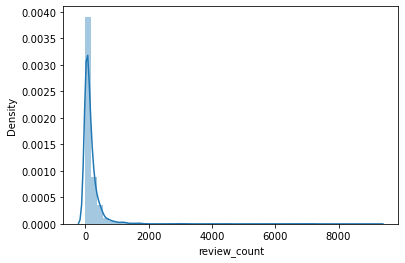

In [9]:
restaurants_in_Portland = open_restaurants[open_restaurants['city'] == 'Portland'].reset_index(drop = True)
sns.distplot(restaurants_in_Portland['review_count'])

In [10]:
restaurant_TO_10plus = restaurants_in_Portland.loc[restaurants_in_Portland['review_count'] >= 10]
restaurant_TO_10plu = restaurant_TO_10plus [restaurant_TO_10plus ['is_open']==1].reset_index(drop = True)
restaurant_final = restaurant_TO_10plus[['business_id', 'name', 'stars']]
restaurant_final = restaurant_final.rename(columns={'name':'business_name', 'stars':'business_stars'})

In [11]:
review_final = review[['review_id', 'business_id', 'stars', 'text']]
review_final = review_final.rename(columns={'stars':'review_stars', 'text':'review_text'})

In [12]:
dataset = restaurant_final.merge(review_final, how='left', on='business_id', sort=True)

In [13]:
dataset.head()

,business_id,business_name,business_stars,review_id,review_stars,review_text
0,--UNNdnHRhsyFUbDgumdtQ,Le Pigeon,4.5,zEbafoN-Vo2wQbCj1whMfg,5.0,Le Pigeon is a dining experience that's a lot ...
1,--UNNdnHRhsyFUbDgumdtQ,Le Pigeon,4.5,a6NrSv_T4EYF3owwSZHl3A,5.0,We felt so attended to with our meal. Two of o...
2,--UNNdnHRhsyFUbDgumdtQ,Le Pigeon,4.5,JEzFYK2E2LW9B5YwAxG3Ng,5.0,This dirty bird does not taste like chicken. ...
3,--UNNdnHRhsyFUbDgumdtQ,Le Pigeon,4.5,ZeC6FStBg-evnHoOqlvKOQ,5.0,As James Osland would say... 5 stars. We love ...
4,--UNNdnHRhsyFUbDgumdtQ,Le Pigeon,4.5,PilFuCiQSt3LIdZVA3euHA,5.0,"Simply amazing. Our waiter, Danny, was very k..."


In [14]:
dataset.isna().sum()

business_id       0
business_name     0
business_stars    0
review_id         0
review_stars      0
review_text       0
dtype: int64

In [15]:
dataset.to_csv(r'/Users/langchen777/Desktop/Portland_merge.csv', index = False)

In [16]:
review.to_csv(r'/Users/langchen777/Desktop/review.csv', index = False)

# Assign Sentiment

In [17]:
binary = False
tri = True
# we assign three sentiments (Positive/Negative/Neutral)

In [18]:
dataset = dataset.loc[:,['review_stars', 'review_text']]

In [20]:
# Function to assign sentiment
def get_sentiment(n, binary=False, tri=False):
    assert n >= 1 and n <= 5 and type(n) == int
    
    if binary:
        if n == 1 or n == 2:
            return 0
        elif n == 3:
            return -1
        else:
            return 1
    elif tri:
        if n == 1 or n == 2:
            return 0
        elif n == 3:
            return 1
        else:
            return 2
    else:
        return int(n)

In [21]:
dataset.head()

,review_stars,review_text
0,5.0,Le Pigeon is a dining experience that's a lot ...
1,5.0,We felt so attended to with our meal. Two of o...
2,5.0,This dirty bird does not taste like chicken. ...
3,5.0,As James Osland would say... 5 stars. We love ...
4,5.0,"Simply amazing. Our waiter, Danny, was very k..."


In [22]:
dataset = dataset.astype({'review_stars': 'int32'})
# Assignment
dataset['sentiment'] = dataset['review_stars'].apply(lambda x : get_sentiment(x, binary = binary, tri = tri))
dataset['sentiment'].value_counts()

2    387486
0     83575
1     58639
Name: sentiment, dtype: int64

In [23]:
dataset = dataset.reset_index(drop=True)

In [24]:
# Remove stars column
dataset = dataset.drop('review_stars', axis=1)
dataset = dataset.rename(columns={'review_text':'review'})

In [25]:
dataset.head()

,review,sentiment
0,Le Pigeon is a dining experience that's a lot ...,2
1,We felt so attended to with our meal. Two of o...,2
2,This dirty bird does not taste like chicken. ...,2
3,As James Osland would say... 5 stars. We love ...,2
4,"Simply amazing. Our waiter, Danny, was very k...",2


In [26]:
dataset.describe()

,sentiment
count,529700.000000
mean,1.573742
std,0.748411
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


# Split Train and Test Datasets

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, test = train_test_split(dataset, train_size=0.75)

In [30]:
train.to_csv(r'/Users/langchen777/Desktop/train.csv', index = False)
test.to_csv(r'/Users/langchen777/Desktop/test.csv', index = False)

In [31]:
X_train = train['review'].tolist()
y_train = train['sentiment'].tolist()

In [32]:
X_test = test['review'].tolist()
y_test = test['sentiment'].tolist()

# Vectorization

In [33]:
import nltk

In [34]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/langchen777/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/langchen777/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/langchen777/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/langchen777/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [35]:
"""
vectorizer
"""
import re
import string

from nltk import PorterStemmer, WordNetLemmatizer, sent_tokenize, wordpunct_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import CountVectorizer


class YelpSentCountVectorizer(CountVectorizer):
    def __init__(self, ngram_range=(1, 1),
                 remove_nonwords=False, remove_stopwords=False,
                 stem=False, lemmatize=False, min_df=1, binary=False):
        super().__init__()
        self.punct = set(string.punctuation)
        self.ngram_range = ngram_range
        self.remove_nonwords = remove_nonwords
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.stemmer = PorterStemmer() if stem else None
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
        self.min_df = min_df
        self.binary = binary

    def lemmatize(self, token, tag):
        tag = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV,
            'J': wordnet.ADJ
        }.get(tag[0], wordnet.NOUN)
        return self.lemmatizer.lemmatize(token, tag)

    def stem(self, token):
        return self.stemmer.stem(token)

    def build_analyzer(self):
        # create the analyzer that will be returned by this method
        def analyser(doc):
            # Keep only words
            doc = re.sub('[^A-Za-z0-9]+', ' ', doc) if self.remove_nonwords else doc
            cleaned_tokens = []
            # Break the document into sentences
            for sent in sent_tokenize(doc):
                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):
                    # Lower case and strip spaces
                    token = token.lower()
                    token = token.strip()
                    # If stopword, ignore token and continue
                    if token in self.stop_words:
                        continue
                    # If punctuation, continue
                    if all(char in self.punct for char in token):
                        continue
                    # Lemmatize/stem the token
                    if self.lemmatizer:
                        token = self.lemmatize(token, tag)
                    elif self.stemmer:
                        token = self.stem(token)
                    cleaned_tokens.append(token)
            # use CountVectorizer's _word_ngrams built in method to extract n-grams
            return self._word_ngrams(cleaned_tokens)

        return analyser

In [36]:
vect = YelpSentCountVectorizer(ngram_range=(1,2),
                                        remove_nonwords=True,
                                        remove_stopwords=True,
                                        stem=False,
                                        lemmatize=True)

In [38]:
%time cv = vect.fit(X_train)

CPU times: user 29min 32s, sys: 34.5 s, total: 30min 6s
Wall time: 30min 29s


In [39]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [41]:
X_train_dtm.to_csv(r'/Users/langchen777/Desktop/train_dtm.csv', index = False)
X_test_dtm.to_csv(r'/Users/langchen777/Desktop/test_dtm.csv', index = False)

AttributeError: to_csv not found

In [42]:
X_train_dtm

<397275x4304288 sparse matrix of type '<class 'numpy.int64'>'
	with 36194091 stored elements in Compressed Sparse Row format>

In [44]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
# save to csv file
savetxt('X_train_dtm.csv', X_train_dtm, delimiter=',')

ValueError: Expected 1D or 2D array, got 0D array instead

In [45]:
import pickle

with open('/Users/langchen777/Desktop/X_train_dtm.pickle', 'wb') as f:
    pickle.dump(X_train_dtm, f)
with open('/Users/langchen777/Desktop/X_test_dtm.pickle', 'wb') as f:
    pickle.dump(X_test_dtm, f)